[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Plant Classification-Histogram Equalization-1

## Instructions
1. Clone the repository.
2. Download the necessary datasets from Eden Repository:
   1. Black nightsade-22/MAY/2019-v1
3. Unzip dataset files and remove the zip files.
4. Create a folder called 'eden_data'.
5. Move the unzipped datasets into this folder.
6. The resulting directory structure should be something similar to:
    * eden_library_notebooks/image_preprocessing/
       * plant_classification-histogram_equalization-1.ipynb
       * eden_data/
           * Black nightsade-220519-Weed-zz-V1-...
7. Install notebook dependencies by running:
    <pre><code>conda env create -f eden_histogram_equalization.yml</code></pre>
8. Open the notebook: jupyter notebook
9. Run the code

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will reply to you as soon as possible.

### Background

This notebook aims to provide some initial experience on simple image processing techniques, in order to provide a better understanding of what an "image" is from a computer vision perspective. Image (pre-)processing is an integral step in any artificial intelligence process. There are many different techniques, such as histogram equalization, median filter, negative image transformation, etc. In this notebook we will focus on the **histogram equalization** technique. Other techniques could be found in the notebooks published in the <a href="http://edenlibrary.ai/">Eden Library platform</a>. Take a look!!

**Contrast** is a parameter that expresses how bright and dark pixels are distributed in the image. Because of complex dynamic lightning conditions or wrong camera configurations, the bright and dark areas of some images could blend together, creating images with a large number of either very dark or very bright pixels that make distinguishing certain relevant features significantly harder. Consequently, this problem could even reduce the performance of a final machine learning classifier. As shown in the figure, the pixel values are gathered around certain peaks on the histogram (See left side of the figure).

**Histogram equalization** is a basic image processing technique that adjusts the global contrast of an image by updating the image histogram’s pixel intensity distribution. As a result, areas of low contrast obtain higher contrast in the output image. Summing up: The result of applying histogram equalization is an **image with higher global contrast**. (See right side of the figure).

<img src="https://upload.wikimedia.org/wikipedia/commons/c/ca/Histogrammeinebnung.png" width="500">

From a computer vision point of view, it could be said that an image is a multi-layer 2d matrix. Each cell inside the matrices represents the respective pixel in the image. These pixels are the values recorded by the sensor (e.g. camera) for a specific position and spectral band. The most common form of imagery is RGB which consists of three layers for the Red, Green and Blue spectra.

#### Library imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
import random

#### Auxiliar functions

In [2]:
def plot_sample(X):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0])-1])

In [3]:
def read_data(path, im_size=(128,128)):
    
    X = []
    
    for im_file in tqdm(glob(path + "*/*")):
        try:
            im = cv2.imread(im_file)
            im = cv2.resize(im, im_size,interpolation=cv2.INTER_LINEAR)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            X.append(im)
        except Exception as e:
            # In case annotations or metadata are found
            print("Not a picture")
    
    X = np.array(X)
    
    return X

#### Auxiliar functions for computing and displaying histograms

In [4]:
def plot_channel_histogram(image, ax):
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    ax.plot(cdf_normalized, color = 'b')
    ax.hist(image.flatten(),256,[0,256], color = 'r')
    ax.legend(('cdf','histogram'), loc = 'upper left')
    
def plot_image_histogram(image, ax):
    color = ('r','g','b')
    for i, col in enumerate(color):
        histr = cv2.calcHist([image],[i],None,[256],[0,256])
        ax.plot(histr,color = col)

#### Experimental constants

In [5]:
IM_SIZE = (256, 256)
IM_PATH = 'eden_data/' # Path to the Eden data

#### Reading and displaying pictures
Some of the pictures inside this dataset are **overexposed**. Therefore, we will use histogram equalization to improve the image quality. 

100%|██████████| 123/123 [00:19<00:00,  6.19it/s]


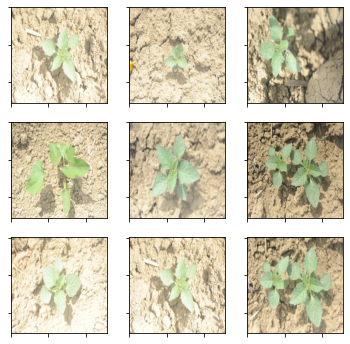

In [6]:
#set the image name
X = read_data(IM_PATH, IM_SIZE)
plot_sample(X)

#### This is the (overexposed) image we will use for computing histrogram equalization

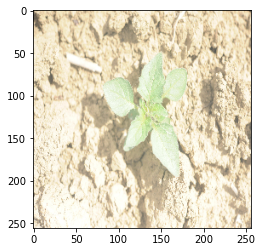

In [7]:
SAMPLE_IMAGE_INDEX = 30
im_sample = X[SAMPLE_IMAGE_INDEX]
plt.imshow(im_sample)
plt.show()

### 1. Grayscale image
In this first example, we will work with a grayscale version of the picture. In other words, only 1 channel is going to be equalized.

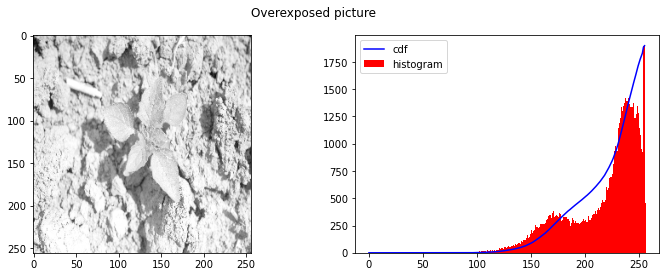

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Overexposed picture')
# Transform RGB image into a grayscale version
gray = cv2.cvtColor(im_sample, cv2.COLOR_RGB2GRAY)
ax1.imshow(gray, cmap="gray")
plot_channel_histogram(gray, ax2)
plt.show()

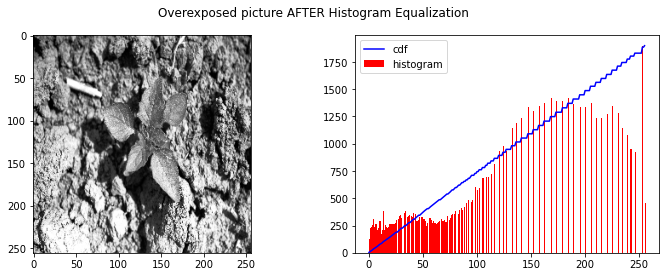

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Overexposed picture AFTER Histogram Equalization')
# Equalizing grayscale image
equ = cv2.equalizeHist(gray)
ax1.imshow(equ, cmap="gray")
plot_channel_histogram(equ, ax2)
plt.show()

### 2. Multi-channel image (RGB)

In this second example, we will work with the original RGB version of the picture. For that reason, each of the 3 channels will be equalized separately.

#### Original Image

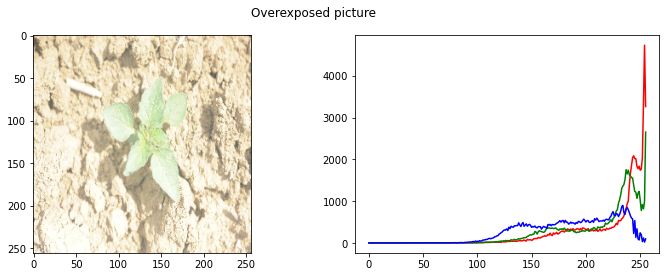

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Overexposed picture')
ax1.imshow(im_sample)

plot_image_histogram(im_sample, ax2)

plt.show()

##### Algorithm
To perform histogram equalization on a multi-channel image it is necessary to: 
1. Split the image into its respective channels
2. Equalize each channel, and
3. Merge the channels back together.

In [11]:
NUM_CHANNELS = 3
# Algorithm: Steps 1 and 2
eqs = [cv2.equalizeHist(im_sample[:,:,i])[:,:,np.newaxis] for i in range(NUM_CHANNELS)]
# Algorithm: Step 3
equalized_image = cv2.merge((eqs[0], eqs[1], eqs[2]))

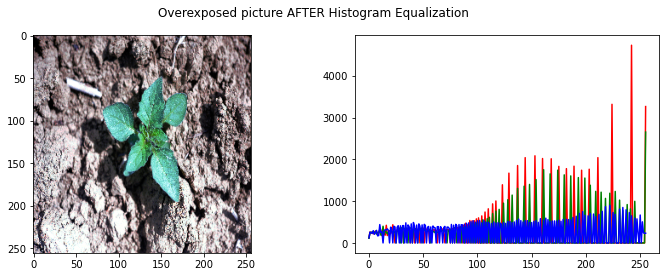

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Overexposed picture AFTER Histogram Equalization')
ax1.imshow(equalized_image)

plot_image_histogram(equalized_image, ax2)
plt.show()

### Bonus: False Colour Images 
We can also rearrange the order that the bands are displayed in. This technique is used by many applications in multispectral data and is widely referred to as "pseudo-color", or simply false colour composites.

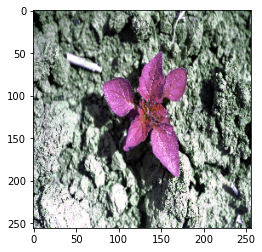

In [13]:
plt.imshow(cv2.merge((eqs[1], eqs[0], eqs[2])))
plt.show()

## Possible Extensions
1. Examine other false colour image configurations.
2. Examine histogram equalization with a different image.

## Bibliography

https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html

https://en.wikipedia.org/wiki/Histogram_equalization

https://www.pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/

https://medium.com/@kyawsawhtoon/a-tutorial-to-histogram-equalization-497600f270e2

https://towardsdatascience.com/histogram-equalization-a-simple-way-to-improve-the-contrast-of-your-image-bcd66596d815

https://www.geeksforgeeks.org/histograms-equalization-opencv/